In [1]:
import bs4
import re
import os
import json

import requests
import urllib
from urllib.parse import urlparse
from urllib.parse import urljoin

import aiohttp
import aiofiles

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Utility functions

In [2]:
def get_json(url):
  return requests.get(url).json()

def get_soup(url):
  return bs4.BeautifulSoup(requests.get(url,verify=False).text)

def download(url,outfile):
  with open(outfile,"wb") as f:
    res = requests.get(url,verify=False)
    f.write(res.content)

def get_base_url(url):
  scheme,netloc,*_= urllib.parse.urlparse(url)
  return f"{scheme}://{netloc}"

async def download_urls_async(urls,out_folder,base_url=None,verbose=True):
  os.makedirs(out_folder,exist_ok=True)
  async with aiohttp.ClientSession(base_url) as session:
    for url in urls:
      async with session.get(url,verify_ssl =False) as res:
        filename =os.path.join(out_folder,url.split("/")[-1])
        print(filename)
        async with aiofiles.open(filename, "wb") as f:
          await f.write(await res.content.read())


## Cleaning

In [123]:
def process_df(df,header_start,header_end=None,footer_start=None,start_column=0):  
  start_row = df[df[start_column].eq(header_start)].index.values[0]
  try:
    end_row = df[df[start_column].eq(footer_start)].index.values[0]
  except:
    end_row = None
  
  df = df.iloc[start_row:end_row,start_column:]
  df.drop(df.iloc[0][df.iloc[0].isna()].index,axis=1,inplace=True)
  df.drop(df.iloc[:,0][df.iloc[:,0].isna()].index,axis=0,inplace=True)
  df.columns = df.iloc[0]
  df.columns.name=None
  try:
    end_row = df.columns.get_loc(header_end)+1
  except:
    end_row =None
  df = df.iloc[1:,:end_row].set_index(header_start,drop=True)
  return df

## AQI Dataset

In [3]:
datasets_homepage = "https://tspcb.cgg.gov.in/Pages/Envdata.aspx"
soup = get_soup(datasets_homepage)

/home/livinnector/anaconda3/envs/ml/lib/python3.10/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tspcb.cgg.gov.in'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [4]:
aqi_links = [
    urllib.parse.unquote(a["href"])
    for a in soup.find_all("a",text=re.compile(".*AQI 20*"))
]
await download_urls_async(aqi_links,"aqi",get_base_url(datasets_homepage))

aqi/AQI 2016.xls
aqi/AQI 2017.xlsx
aqi/Monthly AQI Jan - Dec 2018.xlsx
aqi/MonthlyAQI2019.xlsx
aqi/MonthlyAQI2020.xls
aqi/MonthlyAQI2021.xls
aqi/MonthlyAQI2022.xls


In [239]:
datasets = pd.read_excel("aqi/AQI 2016_2022.xlsx",header=0,index_col=0,sheet_name=None)
for name, dataset in datasets.items():
    dataset.rename(lambda x: x.split(",")[0].strip(),inplace=True)
    print(name,len(dataset.index),len(dataset.index.unique()))
combined_df = pd.concat(datasets.values(),axis=1).sort_index().apply(lambda c: pd.to_numeric(c,errors="coerce"))


AQI 2016 41 41
AQI 2017 42 42
AQI 2018 42 42
AQI 2019 42 42
AQI 2020 42 42
AQI 2021 43 43
AQI 2022 51 51


In [242]:
combined_df.to_excel("aqi/AQI all_processed.xlsx")

In [245]:
len(combined_df.index)

52

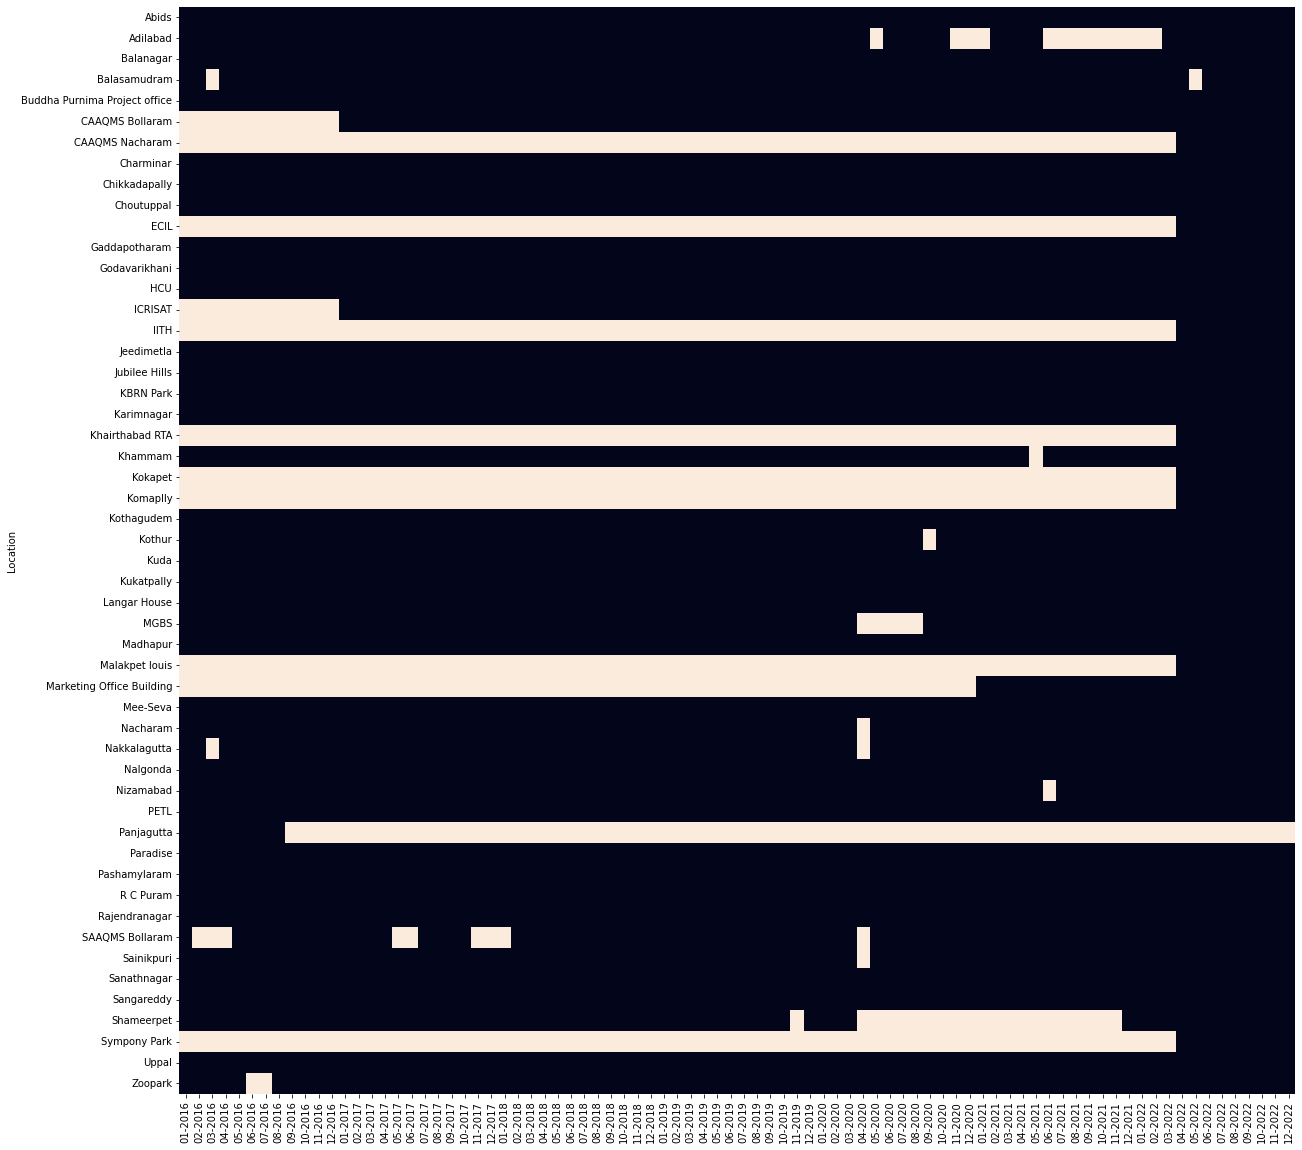

In [240]:
plt.figure(figsize=(20,20))
sns.heatmap(combined_df.isna(),xticklabels=combined_df.columns.to_series().apply(lambda x: datetime.strftime(x,"%m-%Y")),cbar=False);

# AAQ Dataset

In [5]:
aaq_links = [
    urllib.parse.unquote(a["href"])
    for a in soup.find_all("a",text=re.compile(".*AAQ Data 20*"))
]
await download_urls_async(aaq_links,"aaq",get_base_url(datasets_homepage))

aaq/AAQ Data 2016.xls
aaq/AAQ Data 2017.xls
aaq/AAQ Data Jan - Dec 2018.xls
aaq/AAQData2019.xls
aaq/MonthlyAAQData2020.xls
aaq/MonthlyAAQData2021.xls
aaq/MonthlyAAQData2022.xls


In [76]:
start_column = 1
header_start = "S.NO" 
aaq_datasets = sorted(os.listdir("aaq"))

In [78]:
start_column = 1
header_start = "S.NO" 
aaq_datasets = os.listdir("aaq")
processed_datasets = {}
output_folder = "aaq_processed"

os.makedirs(output_folder,exist_ok=True)
for dataset in aaq_datasets:
  xl = pd.read_excel(os.path.join("aaq",dataset),None,header=None)
  xl = {name:process_df(df,header_start,start_column) for name,df in xl.items() }
  processed_datasets[dataset]=xl
  with pd.ExcelWriter(os.path.join(output_folder,dataset)) as writer:
    for name,df in xl.items():
      df.iloc[:,1:]=df.iloc[:,1:].apply(lambda x:pd.to_numeric(x,errors="coerce",downcast="float"))
      drop_columns = [x for x in df.columns[1:] if not isinstance(x,datetime)]
      df.drop(drop_columns,axis=1,inplace=True)
      df.style.format(precision=1).to_excel(writer,sheet_name=name)

/home/livinnector/anaconda3/envs/ml/lib/python3.10/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
/home/livinnector/anaconda3/envs/ml/lib/python3.10/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
/home/livinnector/anaconda3/envs/ml/lib/python3.10/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
/home/livinnector/anaconda3/envs/ml/lib/python3.10/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future vers

In [ ]:
!mkdir -p dirve/MyDrive/datasets/aaq_processed
!cp -r aaq_processed dirve/MyDrive/datasets/aaq_processed

# Vehicle sales dataset



In [ ]:
json = get_json("https://data.telangana.gov.in/api/3/action/package_show?id=a26d65d6-99ce-46e1-930e-84039fbf3a6d")
transport_vehicle_dataset_urls = {item["name"]: item["url"] for item in json["result"][0]["resources"]}  

In [ ]:
await download_urls_async(transport_vehicle_dataset_urls.values(),"transport_vehicle_dataset")

In [ ]:
!rm -r transport_vehicle_dataset

In [ ]:
!mkdir -p drive/MyDrive/datasets/
!cp -r transport_vehicle_dataset drive/MyDrive/datasets

In [ ]:
import pandas as pd

In [ ]:
df= pd.read_csv("/content/ts_transport_vehicle_online_sales_01_01_2019to31_01_2019.csv")
df.head()

In [ ]:
df["fuel"].unique()

In [ ]:
df["seatCapacity"].describe()

In [ ]:
df["vehicleClass"].unique()

In [ ]:
df["modelDesc"].unique(),len(df["modelDesc"].unique())

In [ ]:
pd.read_csv('https://data.telangana.gov.in/sites/default/files/ts_transport_vehicle_online_sales_01_01_2019to31_01_2019.csv`')

# TS-NPDCL Industrial consumption data 

In [ ]:
response = requests.get('https://data.telangana.gov.in/api/3/action/package_show?id=23298d38-cf5f-4954-93c3-c7baa5b63122')
data = json.loads(response.text)

In [ ]:
data=data['result'][0]

In [ ]:
data['resources'][i]['url']

In [ ]:
os.makedirs('Industrial consumption data')

In [ ]:
for i in data['resources']:
  url=i['url']
  filename = os.path.basename(urlparse(url).path)
  urllib.request.urlretrieve(url, 'Industrial consumption data/'+filename)


In [ ]:
paths=os.listdir('Industrial consumption data')

In [ ]:
df1=pd.DataFrame()

In [ ]:
# Merging csv [2019-2022] 
for i in paths:
  df=pd.read_csv('Industrial consumption data/'+i)
  a=i[39:-4].split('-')
  df['date']=pd.to_datetime(a[0]+a[1])
  df1=pd.concat([df1,df])

## EDA

In [ ]:
df1.groupby(by=df1.date).sum()[['Load','Units']].plot(figsize=(15,10),logy=True,kind='bar',subplots=True)

In [ ]:
df1.groupby(by=df1.date).sum()[['Load','Units']].plot(figsize=(15,10),logy=False,kind='line',subplots=True)

In [ ]:
df1.groupby(by=df1.date).mean()[['Load','Units']].plot(figsize=(15,10),logy=False,kind='line',subplots=True)

In [ ]:
df1.groupby(by=[df1.date.dt.year,df1.Circle]).sum()[['Load','Units']].plot(figsize=(15,10),logy=False,kind='bar',subplots=True)

In [ ]:
df1.to_csv('Industrial consumption data.csv')

# Weather dataset

- [2019](https://data.telangana.gov.in/api/3/action/package_show?id=c1c1ac69-928c-496f-880d-f406b2e51572)
- [2020](https://data.telangana.gov.in/api/3/action/package_show?id=6ea39cf0-8e2d-42ce-8088-3778007a62bd)
- [2021](https://data.telangana.gov.in/api/3/action/package_show?id=54ede4bd-ff05-4f71-a1db-177c0ed5dc72)
- [2022](https://data.telangana.gov.in/api/3/action/package_show?id=0b746023-f987-4e5d-bda2-91090c4b57f1)




In [ ]:
import numpy as np

In [ ]:
os.makedirs('weather dataset')

In [ ]:
whether_dataset_urls=[
  'https://data.telangana.gov.in/api/3/action/package_show?id=telangana-weather-data-2022',
  'https://data.telangana.gov.in/api/3/action/package_show?id=telangana-weather-data-2021',
  'https://data.telangana.gov.in/api/3/action/package_show?id=telangana-weather-data-2020',
  'https://data.telangana.gov.in/api/3/action/package_show?id=telangana-weather-data-2019',
  'https://data.telangana.gov.in/api/3/action/package_show?id=telangana-weather-data-2018',
]
def get_csv_urls_from_dataset_url(url):
  dataset = get_json(url)['result'][0]
  return dataset["name"],[resource["url"] for resource in dataset["resources"]]


- datasets for AQI
  - aqi - hyderabad, r_c_puram, warangal
  - AAQ - hyderabad, r_c_puram, warangal
    - so2
    - nox
    - pm10
    - pm2.5
    - co
    - NH3
    - benzene tolune
  - weather - others locations

- Datasets for Heat 
  - D


In [ ]:
paths=os.listdir('/content/weather dataset')

In [ ]:
paths[12]

In [ ]:
fd=pd.DataFrame()

In [ ]:
for i in paths:
  if i[-1]=='x':
    df=pd.read_excel('weather dataset/'+i)
  else:
    df=pd.read_csv('weather dataset/'+i)
  df['Date']=pd.to_datetime(df.Date)
  # print(df.columns)
  fd=pd.concat([fd,df])

In [ ]:
pd.read_csv('weather dataset/april_to_june.csv',header=1).columns

In [ ]:
fd=fd.drop(columns='Unnamed: 0')

In [ ]:
fd.groupby(fd.Date.dt.month).mean().plot(subplots=True,figsize=(15,15))

In [ ]:
fd.plot(kind='line',x='Rainfall (mm)',y=fd.Date.dt.month)

In [ ]:
!rm -r 'weather dataset'

#### Exp

In [ ]:
path="drive/MyDrive/datasets/aqi"

In [ ]:
os.listdir(path)

In [ ]:

pd.read_excel(path,header=4,usecols='B:O',sheet_name=0).dropna()

In [ ]:
os.makedirs('AQI')

In [ ]:
def link_to_csv(links):
  for i in links:
    filename=os.path.basename(urlparse(i).path).replace('%','_')[:-5]
    xlsx = pd.ExcelFile(i)

    for sheet in xlsx.sheet_names:
        df = pd.read_excel(xlsx, sheet_name=sheet,usecols='B:P').dropna(thresh=3).reset_index(drop=True)
        df.to_csv('AQI/'+filename+sheet+'.csv',header=False)
link_to_csv(aqi_links)